<a href="https://colab.research.google.com/github/hazieon/Exoplanet-Detection/blob/dev/Kepler_Exoplanet(Project_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
#connecting to google drive to bring in the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import numpy as np

In [122]:
#file_path='/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv'

#file_path='/content/drive/MyDrive/KeplerExoplanet/kepler_dataset.csv'
# df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/kepler_dataset.csv')
#df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv')
#df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv')
# df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/TESS_data.csv')

#wecan directly use column names with header=0
#7803 data points 39 feature columns
#print few rows of starting default 5

# Kepler data stared at one field of space for four years,
# Looking deeper at the K2 data can provide a new angle of analysing exoplanet features

df = pd.read_csv(
    '/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv',
    comment='#'
)

# PREPROCESSING DATA -
# Strip column names of leading/trailing spaces
df.columns = df.columns.str.strip()

# List of numeric columns to convert
numeric_cols = ['pl_rade', 'pl_eqt', 'pl_orbper', 'pl_insol', 'st_teff', 'st_rad']

# Convert each column to float data type
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df=df.loc[:4000]

# Take a look at the data -
print(df.head(5))

# Dataset overview
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("Total NaNs:", df.isna().sum().sum())
print("Total valid values:", df.size - df.isna().sum().sum())

# Define key columns to check for NaNs
key_columns = ['sy_pnum', 'sy_dist', 'pl_name', 'disposition']  # adjust as needed

# Drop columns with >50% NaN in the key columns
cols_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.5 ]
df = df.drop(columns=cols_to_drop)

# Drop rows where any key column has >50% NaN
rows_to_drop = df[df[key_columns].isna().mean(axis=1) > 0.5].index
df = df.drop(index=rows_to_drop)

# Quick sanity check
print(f"Rows remaining: {df.shape[0]}")
print(f"Columns remaining: {df.shape[1]}")
print(f"Total NaNs: {df.isna().sum().sum()}")



             pl_name        hostname  default_flag disposition  \
0        BD+20 594 b       BD+20 594             0   CONFIRMED   
1        BD+20 594 b       BD+20 594             0   CONFIRMED   
2        BD+20 594 b       BD+20 594             1   CONFIRMED   
3  EPIC 201111557.01  EPIC 201111557             1   CANDIDATE   
4  EPIC 201111557.01  EPIC 201111557             0   CANDIDATE   

             disp_refname  sy_snum  sy_pnum discoverymethod  disc_year  \
0    Espinoza et al. 2016      1.0      1.0         Transit     2016.0   
1    Espinoza et al. 2016      1.0      1.0         Transit     2016.0   
2    Espinoza et al. 2016      1.0      1.0         Transit     2016.0   
3  Livingston et al. 2018      1.0      0.0         Transit     2018.0   
4  Livingston et al. 2018      1.0      0.0         Transit     2018.0   

  disc_facility  ... sy_vmagerr2  sy_kmag sy_kmagerr1  sy_kmagerr2  \
0            K2  ...      -0.012    9.368       0.018       -0.018   
1            K2  .

In [124]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Label the binary target: 1 = CONFIRMED, 0 = non-planets and candidates
# We took a more conservative approach and excluded candidates from the exoplanet category
df['ConfirmedExoplanet'] = df['disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

# Separate confirmed and non-confirmed planets
confirmed = df[df['ConfirmedExoplanet'] == 1]
non_planet = df[df['ConfirmedExoplanet'] == 0]

# BALANCING THE DATA SETS FOR RELIABILITY, VALIDITY AND TO BETTER TRAIN THE MODEL -
# Undersample the majority class ('CONFIRMED') to match the number of minority class samples ('non-planet')
confirmed_downsampled = resample(confirmed,
                                  replace=False,
                                  n_samples=len(non_planet), # Sample size is now the number of non-planets
                                  random_state=42)

# Combine and shuffle
df_balanced = pd.concat([confirmed_downsampled, non_planet]).sample(frac=1, random_state=42)

# Select numeric features
numeric_cols = df_balanced.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in ['ConfirmedExoplanet']]
X = df_balanced[feature_cols]
y = df_balanced['ConfirmedExoplanet']

# Train/test split (stratified for better balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)



print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())

# Normalisation
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Check for NaNs
print("NaNs in X_train_normalized:", np.isnan(X_train_normalized).sum())
print("NaNs in X_test_normalized:", np.isnan(X_test_normalized).sum())
X_train_normalized = np.nan_to_num(X_train_normalized, nan=0.0)
X_test_normalized = np.nan_to_num(X_test_normalized, nan=0.0)


print("2 NaNs in X_train_normalized:", np.isnan(X_train_normalized).sum())
print("2 NaNs in X_test_normalized:", np.isnan(X_test_normalized).sum())

Training set distribution:
 ConfirmedExoplanet
1    1267
0    1266
Name: count, dtype: int64
Testing set distribution:
 ConfirmedExoplanet
0    423
1    422
Name: count, dtype: int64
NaNs in X_train_normalized: 19281
NaNs in X_test_normalized: 6622
2 NaNs in X_train_normalized: 0
2 NaNs in X_test_normalized: 0


Accuracy: 0.9940828402366864
Confusion Matrix:
 [[418   5]
 [  0 422]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       423
           1       0.99      1.00      0.99       422

    accuracy                           0.99       845
   macro avg       0.99      0.99      0.99       845
weighted avg       0.99      0.99      0.99       845



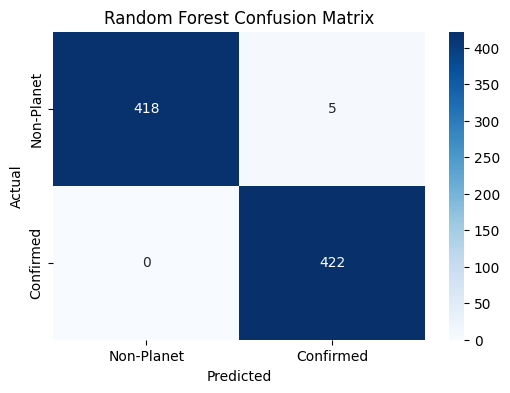

                                    Feature  Importance
2               Number of planets in system    0.471458
0                              default_flag    0.092005
35       System distance (+ variation) (pc)    0.038436
36       System distance (- variation) (pc)    0.037341
20  Host star temperature (- variation) (K)    0.031850
15  Planet radius (- variation) (R_Jupiter)    0.028831
19  Host star temperature (+ variation) (K)    0.025961
11                              pl_radeerr2    0.022333
14                              pl_radjerr1    0.020569
34                     System distance (pc)    0.014605


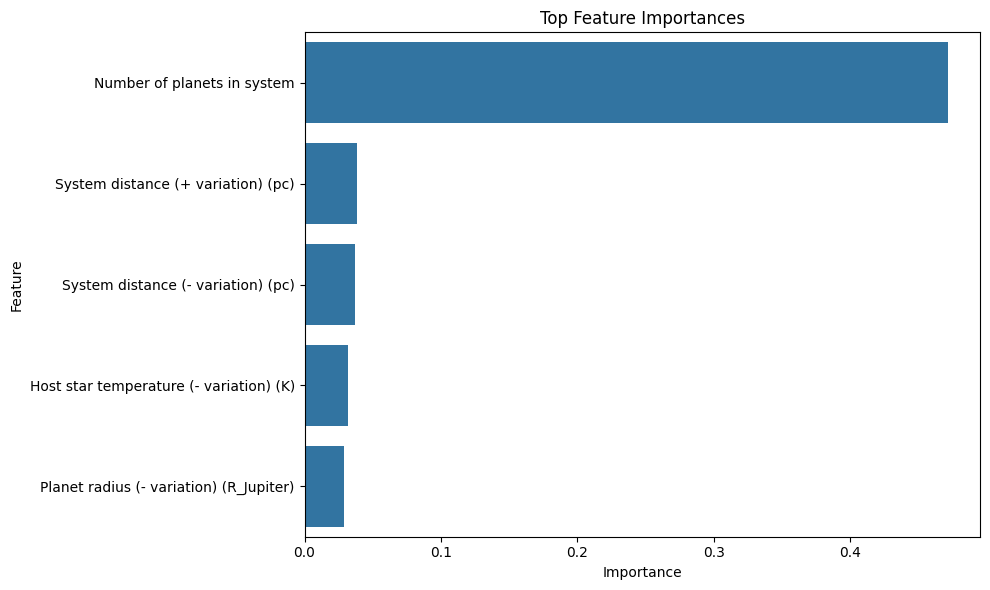

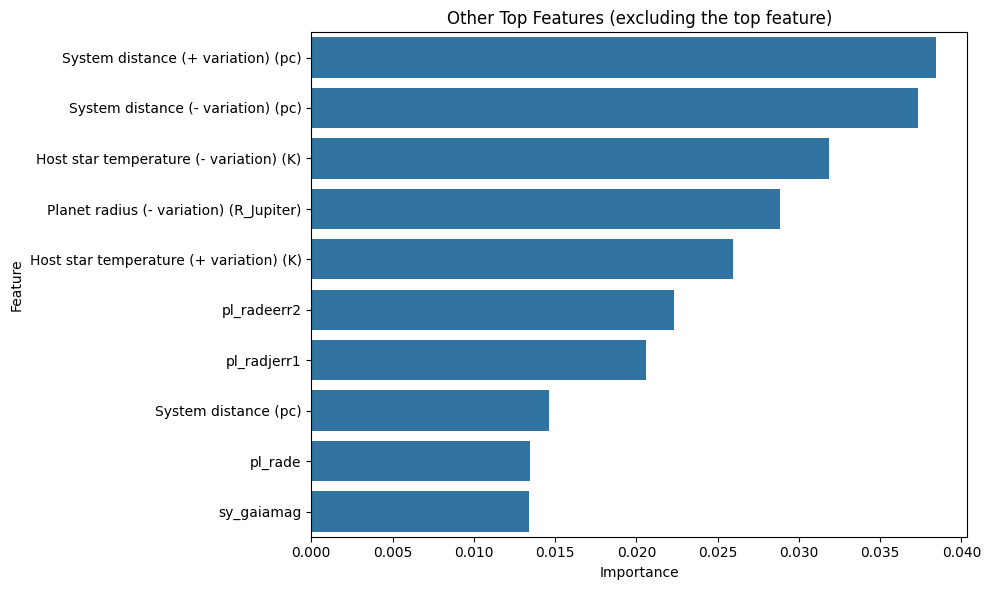

In [125]:
# Random Forest Classifier - Classical machine learning analysis

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# Instantiate Random Forest with anti-overfitting tweaks
# Initially the model returned a suspicious 100% accuracy, so added more anti-overfitting parameters
rf = RandomForestClassifier(
    n_estimators=100,       # number of trees
    min_samples_split=10,   # minimum samples to split a node
    max_features='sqrt',    # only consider sqrt(total_features) per split
    random_state=42
)

# Fit the model
rf.fit(X_train_normalized, y_train)

# Predict
y_pred = rf.predict(X_test_normalized)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


#VISUALISATION OF RESULTS -
# Visualise confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Planet','Confirmed'], yticklabels=['Non-Planet','Confirmed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


# A dictionary of human-readable names for important columns:
readable_names = {
    'sy_pnum': 'Number of planets in system',
    'st_masserr1': 'Host star mass (+ variation) (Solar masses)',
    'st_masserr2': 'Host star mass (- variation) (Solar masses)',
    'sy_disterr1': 'System distance (+ variation) (pc)',
    'sy_disterr2': 'System distance (- variation) (pc)',
    'pl_orbsmaxerr1': 'Semi-major axis (+ variation) (AU)',
    'pl_orbsmaxerr1': 'Semi-major axis (+ variation) (AU)',
    'pl_orbsmaxerr2': 'Semi-major axis (- variation) (AU)',
     'pl_radjerr2': 'Planet radius (- variation) (R_Jupiter)',
    'sy_dist': 'System distance (pc)',
    'st_tefferr2': 'Host star temperature (- variation) (K)',
    'st_tefferr1': 'Host star temperature (+ variation) (K)',
    'st_mass': 'Host star mass (Solar masses)',
    'pl_orbsmaxlim': 'Semi-major axis limit flag',
    'pl_radj' : 'Planetary radius (in Jupiter radii)',
    'sy_kmag' : 'Star brightness (infrared, K-band)'
}

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns


# Map to human-readable names if available
readable_feature_names = [readable_names.get(f, f) for f in feature_names]

# Take a look at most important features in the categorisation
feat_imp_df = pd.DataFrame({
    'Feature': readable_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feat_imp_df.head(10))

# Remove redundant features for categorisation
feat_imp_df = feat_imp_df[~feat_imp_df['Feature'].isin(['default_flag', 'disc_year'])]


# Separate the top feature with highest domainance
# (it overshadows the sensitivity of other features)
top_feature = 'Number of planets in system'
top_feat_df = feat_imp_df[feat_imp_df['Feature'] == top_feature]
other_feats_df = feat_imp_df[feat_imp_df['Feature'] != top_feature]


# Plot top 10 most important features,
# this is highlighting the importance of features highly correlated with the presence of confirmed exoplanets
feat_imp_df = feat_imp_df.head(5)



with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
   # palette='viridis',
    legend=False # <-- disables extra legend
)

plt.title('Top Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Bar chart for other key features
# Plot the remaining features (top 15)
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=other_feats_df.head(10),
     legend=False # <-- disables extra legend
)

plt.title('Other Top Features (excluding the top feature)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()





In [154]:
from tensorflow.keras.layers import Dense, Dropout, ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD

#Building Neural Network Model
model=Sequential()

# Add input layer
model.add(Dense(units=32,activation='sigmoid', input_shape=(X_train_normalized.shape[1],)))

# Add hidden layers
model.add(Dense(units=16,activation='sigmoid'))
model.add(Dense(16))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(units=8,activation='sigmoid'))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1,activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()



# model = Sequential([
#     Dense(32, activation='tanh', input_shape=(X_train_normalized.shape[1],)),
#     Dropout(0.3),
#     Dense(8, activation='tanh'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')  # output layer, for binary classification
# ])

# model.compile(
#     optimizer=SGD(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # Print the summary of the model
# model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 32)             │         1,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,449 (9.57 KB)

 Trainable params: 2,449 (9.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5286 - loss: 0.6974 - val_accuracy: 0.6469 - val_loss: 0.6876
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5275 - loss: 0.6944 - val_accuracy: 0.7456 - val_loss: 0.6782
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5807 - loss: 0.6815 - val_accuracy: 0.8028 - val_loss: 0.6573
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6323 - loss: 0.6602 - val_accuracy: 0.8343 - val_loss: 0.6117
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7367 - loss: 0.6054 - val_accuracy: 0.8402 - val_loss: 0.5372
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8008 - loss: 0.5358 - val_accuracy: 0.8698 - val_loss: 0.4578
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8331 - loss: 0.4587 - val_accuracy: 0.8915 - val_loss: 0.3768
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8883 - loss: 0.3720 - val_accuracy: 0.9112 - val_loss:

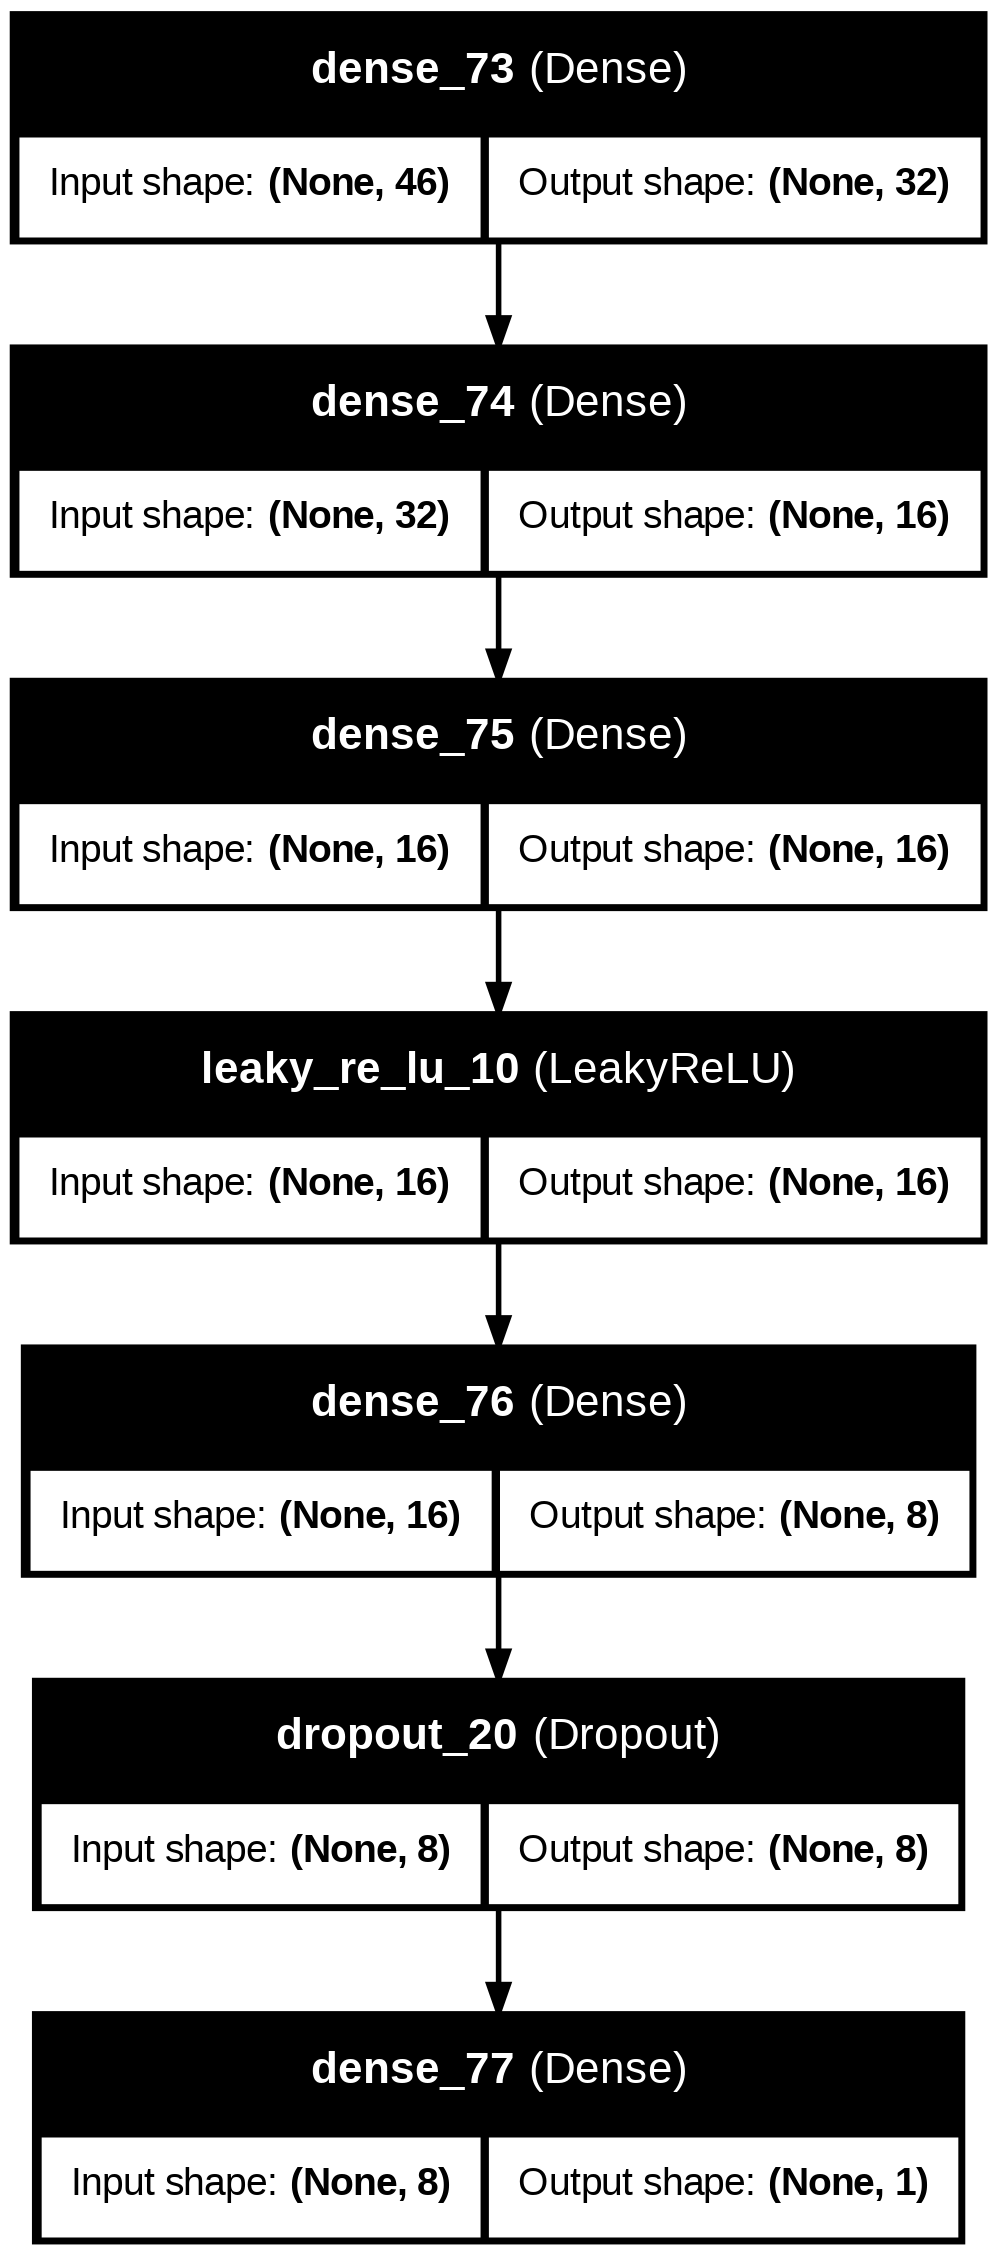

In [155]:
# Train the model
model.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_normalized, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

from tensorflow.keras.utils import plot_model

# Plot the model architecture and display it
plot_file = 'model_plot.png'
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the plot inline
display(Image(filename=plot_file))


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9880 - loss: 0.0649 - val_accuracy: 0.9882 - val_loss: 0.0538
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9868 - loss: 0.0593 - val_accuracy: 0.9882 - val_loss: 0.0541
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9902 - loss: 0.0639 - val_accuracy: 0.9893 - val_loss: 0.0543
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9887 - loss: 0.0570 - val_accuracy: 0.9893 - val_loss: 0.0526
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9897 - loss: 0.0552 - val_accuracy: 0.9893 - val_loss: 0.0535
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9878 - loss: 0.0673 - val_accuracy: 0.9893 - val_loss: 0.0526
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9886 - loss: 0.0617 - val_accuracy: 0.9893 - val_loss: 0.0522
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9870 - loss: 0.0613 - val_accuracy: 0.9893 - val_loss:

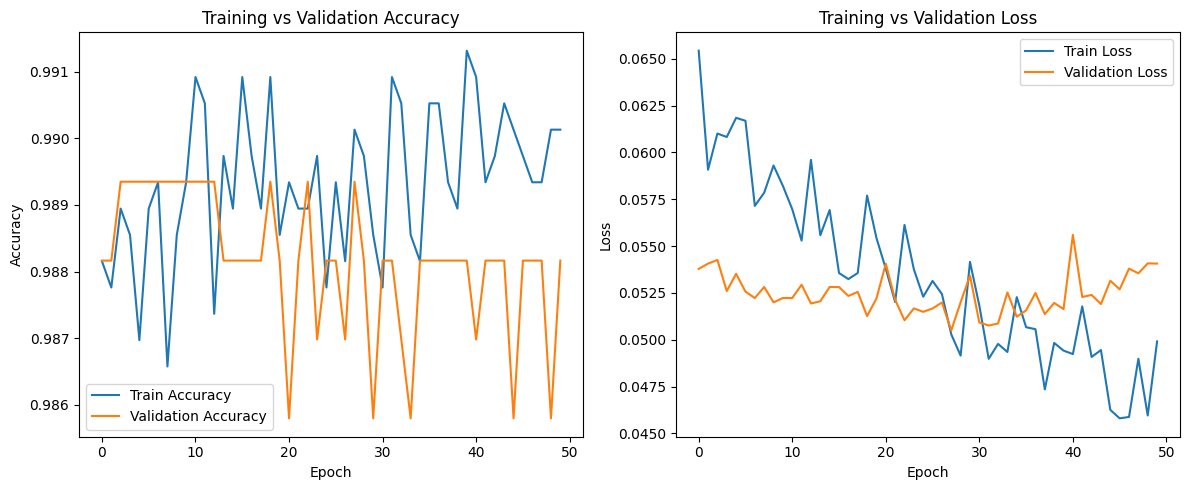

In [156]:
# Fit the model and store history
history = model.fit(
    X_train_normalized,
    y_train,
    validation_data=(X_test_normalized, y_test),
    epochs=50,
    batch_size=64,
    verbose=1
)

# Plot accuracy and loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#High accuracy, low loss:
# Training accuracy ~98–99%
# Validation accuracy ~98.9%
# Validation loss ~0.06


In [ ]:
# @title
# #first we split then we normalize to prevent data leakage and increase accuracy
# l=['ExoplanetCandidate','ExoplanetConfirmed']
# X=df.drop(l,axis=1)  # Features (excluding the target column)
# y=df['ExoplanetCandidate']  # Target variable
# #Splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/7000, random_state=42,
#                                                     stratify=y # ensures class balance in train/test
# )

# Binary target: 1 = CONFIRMED (CONFIRMED exoplanets only), 0 = non-planets (CANDIDATE, FALSE POSITIVE, REFUTED, etc.)
df['ConfirmedExoplanet'] = df['disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

# Select numeric columns as features
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in ['ConfirmedExoplanet']]
X = df[feature_cols]
y = df['ConfirmedExoplanet']


# #Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,
                                                    stratify=y # ensures class balance in train/test
 )

print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())


#Normalizatiom
scaler=StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)


